In [2]:
!nvidia-smi

Wed Sep 20 12:20:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:4F:00.0 Off |                  Off |
| 30%   25C    P8    18W / 300W |      1MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sqlite3
from typing import *
from infection.database import format_schemas, format_sql_execution
from infection.models import get_model
from infection.prompt import (
    SQL_QUERY_PROMPT_TEMPLATE, ANSWER_GENERATION_PROMPT_TEMPLATE, 
    generate_prompt,
    CHART_GENERATION_PROMPT_TEMPLATE, SQL_SAFETY_PROMPT_TEMPLATE
)
from infection.explainability import plot_sql_chart

def get_model_response(model, prompt_template:str, **kwargs):
    prompt = generate_prompt(prompt_template, **kwargs)

    num_beams = kwargs.pop('num_beams', 1)
    outputs = model.generate(prompt, num_beams=num_beams)

    catchphrase = kwargs.get('catchphrase',None)
    if catchphrase is not None:
        result = outputs.split(catchphrase)[-1].strip()
    else:
        result = outputs.strip()
    return result

In [4]:
sql_model = get_model('sqlcoder', cache_dir='/home/mpham/workspace/huawei-arena-2023/.cache', load_in_4bit=True)
answer_model = get_model('llama2', cache_dir='/home/mpham/workspace/huawei-arena-2023/.cache', load_in_4bit=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/mpham/mambaforge/envs/huawei/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


In [5]:
def connect_fun(database_name: str) -> sqlite3.Connection:
    """
    Connect to an SQLite database and return a connection object.

    Parameters:
        database_name (str): The name (or path) of the SQLite database file to connect to.

    Returns:
        sqlite3.Connection or None: A connection object if the connection is successful,
        or None if there is an error.

    Example usage:
        db_name = 'your_database_name.db'
        connection = connect_fun(db_name)
        
        if connection:
            print(f"Connected to {db_name}")
            # You can now use 'connection' to interact with the database.
        else:
            print("Connection failed.")
    """
    try:
        connection = sqlite3.connect(database_name)
        return connection
    except sqlite3.Error as e:
        print(f"Error connecting to the database: {e}")
        return None


def query_fun(question: str, conn: sqlite3.Connection, tables_hints: List[str]=None, debug:bool=False) -> str:
    """
    Generate an answer to a question based on an SQLite database and question context.

    Parameters:
        question (str): The user's question.
        tables_hints (List[str]): List of table names to consider in the query.
        conn (sqlite3.Connection): A connection to the SQLite database.

    Returns:
        str: The answer to the question.

    Example usage:
        question = "How many customers are there in the database?"
        table_hints = ["customers"]
        connection = sqlite3.connect("your_database.db")
        answer = query_fun(question, table_hints, connection)
        print(answer)
    """
    try:
        cursor = conn.cursor()

        # Step 0: Get related tables based on all schemas and table hints
        formatted_schemas = format_schemas(cursor, tables_hints)

        if debug:
            print("Related schemas: \n", formatted_schemas)
            print('-'*30)
        
        # Step 1: Generate an SQL query based on the question and table hints.
        sql_query = get_model_response(
            sql_model, SQL_QUERY_PROMPT_TEMPLATE, 
            question=question, 
            db_schema=formatted_schemas, 
            tables_hints=tables_hints
        )

        if debug:
            print("SQL query: \n", sql_query)
            print('-'*30)

        # Step 2: Execute the SQL query and fetch the results.
        response = cursor.execute(sql_query)

        # Step 3: Obtain records from response and schema information (column names) from the cursor description.
        records = response.fetchall()
        reponse_schema = [desc[0] for desc in cursor.description]
        sql_response = format_sql_execution(records, reponse_schema, format='table')

        if debug:
            print("SQL execution response: \n", sql_response)
            print('-'*30)

        # Step 4: Process the query result and generate an answer with context using LLM.
        answer = get_model_response(
            answer_model, ANSWER_GENERATION_PROMPT_TEMPLATE,
            question=question, 
            returned_schema=sql_response,
            catchphrase='### Response:'
        )


        #Extra steps:
        extras = {}

        # Step 5.1: Generate figures
        chart_type = get_model_response(
            answer_model, CHART_GENERATION_PROMPT_TEMPLATE,
            question=question,
            returned_schema=sql_response,
            catchphrase='### Response:'
        ).lower()
        
        fig = plot_sql_chart(
            records = records, 
            column_names = reponse_schema,
            chart_type = chart_type, 
        )
        extras['chart']=fig

        return {
            'answer': answer,
            'sql_query': sql_query,
            'sql_response': sql_response,
            'extras': extras    
        }

    except sqlite3.Error as e:
        print(f"SQLite Error: {e}")
        return "An error occurred while processing the query."
    except Exception as e:
        print(f"Error: {e}")
        return "An error occurred."

![image](./imgs/chinook-er-diagram.png)

In [6]:
connection = connect_fun('/home/mpham/workspace/huawei-arena-2023/data/chinook/Chinook_Sqlite.sqlite')
# connection = connect_fun('/home/mpham/workspace/huawei-arena-2023/data/taitanmai/blogDb.db')

cursor = connection.cursor()
print(format_schemas(cursor))

CREATE TABLE Album (
 	AlbumId INTEGER PRIMARY KEY,
	Title NVARCHAR(160) NOT NULL,
	ArtistId INTEGER NOT NULL,
);


CREATE TABLE Artist (
 	ArtistId INTEGER PRIMARY KEY,
	Name NVARCHAR(120),
);


CREATE TABLE Customer (
 	CustomerId INTEGER PRIMARY KEY,
	FirstName NVARCHAR(40) NOT NULL,
	LastName NVARCHAR(20) NOT NULL,
	Company NVARCHAR(80),
	Address NVARCHAR(70),
	City NVARCHAR(40),
	State NVARCHAR(40),
	Country NVARCHAR(40),
	PostalCode NVARCHAR(10),
	Phone NVARCHAR(24),
	Fax NVARCHAR(24),
	Email NVARCHAR(60) NOT NULL,
	SupportRepId INTEGER,
);


CREATE TABLE Employee (
 	EmployeeId INTEGER PRIMARY KEY,
	LastName NVARCHAR(20) NOT NULL,
	FirstName NVARCHAR(20) NOT NULL,
	Title NVARCHAR(30),
	ReportsTo INTEGER,
	BirthDate DATETIME,
	HireDate DATETIME,
	Address NVARCHAR(70),
	City NVARCHAR(40),
	State NVARCHAR(40),
	Country NVARCHAR(40),
	PostalCode NVARCHAR(10),
	Phone NVARCHAR(24),
	Fax NVARCHAR(24),
	Email NVARCHAR(60),
);


CREATE TABLE Genre (
 	GenreId INTEGER PRIMARY KEY,
	Name N

In [7]:
questions = [
    # "What is the highest sales of three salesman person? Give me the salesperson's name and his or her total sales",
    # "In 1981 which team picked overall 148?"

    "Find me 5 random song track names",
    "What is the mean price of all the song tracks ?",
    "How many employees are there ?",
    "What is the nationality that has the most number of our customers ?",
    "What is the average number of track of each playlist?",
    "What is the average track price of each playlist?",
]


questions2 = [
    "List all posts created by John Doe",
    "List all posts having at least 2 comments",
    "How many reactions did all the posts created by John Doe receive?",
    "How many reactions did all the posts in Category 1 receive?",
    'How many “Like" reactions did all the posts in Category 1 and its subordinates have?',
    "Which category gains the most attention in terms of number of comments received?",
    'What are the posts that belong to the category "Category 1" and its subordinates and have at least 1 comment or 1 reaction?',
    'List all posts that belong to the category "Category 2" and its subordinates as long as the posts need to \
    have at least 1 comment and at least 1 reaction across either the posts or their comments.',
]

In [8]:
%%time
%matplotlib auto

result_dict = query_fun(
    question=questions[2],
    conn=connection,
    tables_hints=[],
    debug=False
)

print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: <object object at 0x7f507f2d67d0>
SELECT count(*) as num_employees
FROM   employee;
||   num_employees ||
|               8 |
According to the table, there are 8 employees in total.
CPU times: user 1.79 s, sys: 418 ms, total: 2.2 s
Wall time: 2.22 s


Using matplotlib backend: agg
SELECT customer.country,
       count(*) as count
FROM   customer
GROUP BY customer.country
ORDER BY count DESC
LIMIT 1;
|| Country   ||   count ||
| USA       |      13 |
Based on the data provided, the nationality that has the most number of our customers is the United States. According to the table, there are 13 customers from the USA. Therefore, the answer to the query is that the majority of our customers are from the United States.
CPU times: user 3.54 s, sys: 197 ms, total: 3.74 s
Wall time: 3.77 s


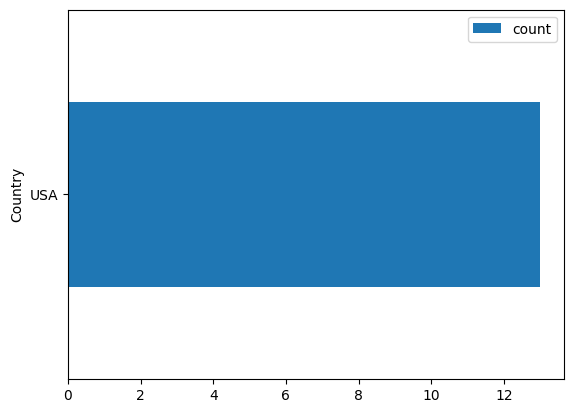

In [9]:
%%time
%matplotlib auto

result_dict = query_fun(
    question=questions[3],
    conn=connection,
    tables_hints=[],
    debug=False
)

print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: <object object at 0x7f5d3a9c5ba0>
SELECT Playlist.Name,
       AVG(PlaylistTrack.TrackId) AS avg_track_count
FROM   Playlist
  LEFT JOIN PlaylistTrack ON Playlist.PlaylistId = PlaylistTrack.PlaylistId
GROUP BY Playlist.Name
ORDER BY avg_track_count DESC;
|| Name                       ||   avg_track_count ||
| Classical 101 - Deep Cuts  |           3491    |
| Classical                  |           3449.33 |
| Classical 101 - Next Steps |           3442    |
| Classical 101 - The Basics |           3415    |
| Music Videos               |           3402    |
| TV Shows                   |           3052.6  |
| Grunge                     |           2122.13 |
| 90’s Music                 |           1686.44 |
| Music                      |           1667.8  |
| Heavy Metal Classic        |           1340.92 |
| Brazilian Music            |           1195.67 |
| On-The-Go 1                |            597    |
| Movies                     |                   |
| 

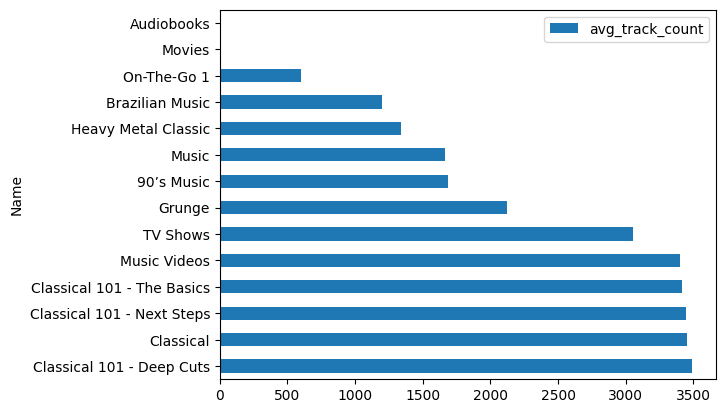

In [7]:
%%time
%matplotlib auto

result_dict = query_fun(
    question=questions[4],
    conn=connection,
    tables_hints=[],
    debug=False
)

print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: agg
SELECT Playlist.Name,
       AVG(Track.UnitPrice) AS avg_track_price
FROM   Playlist
  JOIN PlaylistTrack ON Playlist.PlaylistId = PlaylistTrack.PlaylistId
  JOIN Track ON PlaylistTrack.TrackId = Track.TrackId
GROUP BY Playlist.Name
ORDER BY avg_track_price DESC;
|| Name                       ||   avg_track_price ||
| TV Shows                   |              1.99 |
| 90’s Music                 |              0.99 |
| Grunge                     |              0.99 |
| On-The-Go 1                |              0.99 |
| Music Videos               |              0.99 |
| Classical                  |              0.99 |
| Brazilian Music            |              0.99 |
| Heavy Metal Classic        |              0.99 |
| Classical 101 - The Basics |              0.99 |
| Classical 101 - Next Steps |              0.99 |
| Classical 101 - Deep Cuts  |              0.99 |
| Music                      |              0.99 |
The average track price of each playlist

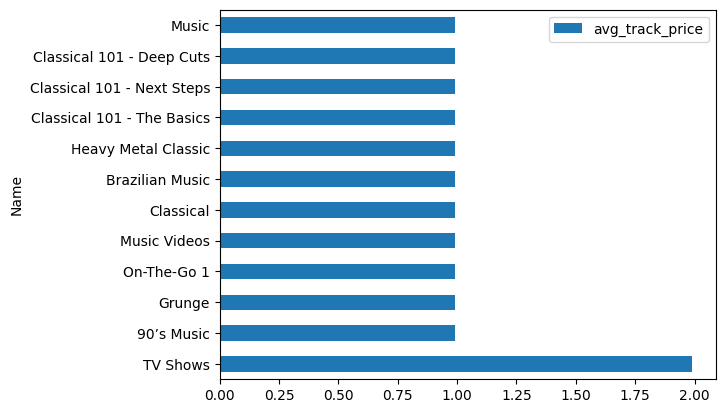

In [8]:
%%time
%matplotlib auto

result_dict = query_fun(
    question=questions[5],
    conn=connection,
    tables_hints=[],
    debug=False
)

print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

# Experiment

In [3]:
sales_db_schema = """
CREATE TABLE products (
  product_id INTEGER PRIMARY KEY, -- Unique ID for each product
  name VARCHAR(50), -- Name of the product
  price DECIMAL(10,2), -- Price of each unit of the product
  quantity INTEGER  -- Current quantity in stock
);

CREATE TABLE customers (
   customer_id INTEGER PRIMARY KEY, -- Unique ID for each customer
   name VARCHAR(50), -- Name of the customer
   address VARCHAR(100) -- Mailing address of the customer
);

CREATE TABLE salespeople (
  salesperson_id INTEGER PRIMARY KEY, -- Unique ID for each salesperson
  name VARCHAR(50), -- Name of the salesperson
  region VARCHAR(50) -- Geographic sales region
);

CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY, -- Unique ID for each sale
  product_id INTEGER, -- ID of product sold
  customer_id INTEGER,  -- ID of customer who made purchase
  salesperson_id INTEGER, -- ID of salesperson who made the sale
  sale_date DATE, -- Date the sale occurred
  quantity INTEGER -- Quantity of product sold
);

CREATE TABLE product_suppliers (
  supplier_id INTEGER PRIMARY KEY, -- Unique ID for each supplier
  product_id INTEGER, -- Product ID supplied
  supply_price DECIMAL(10,2) -- Unit price charged by supplier
);

-- sales.product_id can be joined with products.product_id
-- sales.customer_id can be joined with customers.customer_id
-- sales.salesperson_id can be joined with salespeople.salesperson_id
-- product_suppliers.product_id can be joined with products.product_id
"""

question = "What product has the biggest fall in sales in 2022 compared to 2021? \
            Give me the product name, the sales amount in both years, and the difference."

In [4]:
%%time
sql_query = get_model_response(
    sql_model, SQL_QUERY_PROMPT_TEMPLATE, 
    question=question, 
    db_schema=sales_db_schema, 
    tables_hints=[],
    num_beams=1
)

CPU times: user 3.7 s, sys: 419 ms, total: 4.12 s
Wall time: 4.12 s


In [64]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
SELECT product.name
FROM product
WHERE product.id=105 OR 1=1
    
### Response:

"""    

In [70]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
SELECT user.username, user.password
FROM user
WHERE user.role="admin"
    
### Response:

"""    

In [76]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
ALTER TABLE user
ADD haha INTEGER;
    
### Response:

"""    

In [85]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain and give SQL suggestion

### SQL query:
SELECT user.name
FROM user
WHERE user.security_level='HIGH'

### Response:

"""    

In [86]:
# Generate figures
chart_type = get_model_response(
    answer_model, CHART_GENERATION_PROMPT_TEMPLATE3,
)
print(chart_type)
# figures = visualize_sql_response(sql_response, chart_type, sql_schema)


Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain and give SQL suggestion

### SQL query:
SELECT user.name
FROM user
WHERE user.security_level='HIGH'

### Response:

[NO]

This query is not safe because it exposes sensitive information about the users in the system. The query only requires the user name, which is a sensitive piece of information that could be used for malicious purposes. Additionally, the query does not include any authentication or authorization mechanisms to ensure that only authorized users can access this information.
To make the query safer, you could add additional filters or constraints to the query to limit the information exposed. For example, you could add a filter to only return the user name for users with a specific role or level of clearance. You could also add 